<a href="https://colab.research.google.com/github/OmerDiaaeldin/testrepo/blob/main/NNFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building a neural network from scratch

Trying to build the neural network using OOP <br>
I'll define a layer class, then use it to define a neural network class

In [98]:
import numpy as np

In [99]:
# Define a layer class, now this is a base class for generally any NN layer. All
# layers have input, output, forward_prop, backward_prop. Now depending on the NN
# one.
# one can use this base class to add features specific to the application they have in
# mind (Pooling, convolution, activation,...etc) 

class Layer:

  def __init__(self):
    self.input = None
    self.output = None

  #returns the output of the layer given the input
  def forward_propagation(self, input):
    return NotImplementedError

  #returns the dE/dX for a given dY/dX (and update parameters)
  def backward_propagation(self, output_error, learning_rate):
    return NotImplementedError

In [100]:
class FCLayer(Layer):

  def __init__(self, input_size, output_size):
    super().__init__()
    self.W = np.random.rand(output_size, input_size) - 0.5 #initialize W, the parameter matrix
    self.b = np.random.rand(output_size, 1) - 0.5 #initialize b, the bias

  #for the forward propagation I'm going to feed it W and the input, and return from it the output of the layer
  def forward_propagation(self, input):
    #print(f"W's shape : {self.W.shape}")
    #print(f"X's shape : {input.shape}")
    #print(f"b's shape : {self.b.shape}")
    self.input = input  #assign the layer input when forward propagating
    self.output = np.matmul(self.W, self.input) + self.b
    #print(self.output[0])
    return self.output

  #computes dE/dW and dE/db for a given output_error = dE/dY, updates W and b, and finally returns dE/dX
  def backward_propagation(self, output_error, learning_rate):
    input_error = np.matmul(np.transpose(self.W),output_error)
    W_error = np.matmul(output_error, np.transpose(self.input))
    #b_error = output_error
    #print(f"output's error : {output_error.shape}")
    #print(f"b's error : {b_error.shape}")

    #update the parameters
    self.W -= learning_rate * W_error
    self.b -= learning_rate * np.sum(output_error,axis=1,keepdims=True)

    return input_error


Now let's code some non-linear layers


In [101]:

class ActivationLayer(Layer):

  def __init__(self, activation, activation_derivative):
    super().__init__()
    self.activation = activation
    self.activation_derivative = activation_derivative

  def forward_propagation(self, input):
    self.input = input
    self.output = self.activation(self.input)
    return self.output

  def backward_propagation(self, output_error, learning_rate):
    return self.activation_derivative(self.input)*output_error


tanh and relu activations


In [102]:
def tanh(x):
  return np.tanh(x)

def tanh_derivative(x):
  return (1-np.tanh(x)**2)

def relu(x):
  return max(0,x)

def relu_derivative(x):
  return (x>0)*1

def sigmoid(x):
  return 1/(1+np.exp(-x))

def sigmoid_derivative(x):
  s = sigmoid(x)
  return s*(1-s)  

Time to code losses


In [103]:
def mse(y_true, y_pred):
  return np.mean(np.power(y_true-y_pred,2))

def mse_derivative(y_true, y_pred):
  return 2*(y_pred-y_true)/y_true.size

def entropy(y_true, y_pred):
  #print("y_pred min = ", np.min(y_pred))
  lg1 = np.log(y_pred)
  print("lg1 min",np.min(lg1))
  z1 = -1*np.multiply(y_true,lg1)
  lg0 = np.log(1-y_pred)
  print("lg0 min",np.min(lg0))
  z0 = -1*np.multiply(1-y_true,lg0)
  z = np.mean(z0 + z1)
  return np.mean(z)

def entropy_derivative(y_true, y_pred):
  result = -y_true*1/y_pred + (1-y_true)/(1-y_pred)
  return result

In [104]:
def accuracy(y_true, y_pred):

  z = np.argmax(y_pred, axis = 0)
  prediction = np.zeros(y_pred.shape)
  for element in enumerate(z):
    prediction[tuple(reversed(element))] = 1

  return 100*(1 - (np.sum(np.abs(y_true-prediction))//2)/prediction.size)

# Finally the network class

In [105]:
class Network:  #it is basically a list of layer objects
  def __init__(self):
    self.loss = None
    self.layers = []
    self.loss_derivative = None

  #adds a layer object to the network
  def add(self, layer):
    self.layers.append(layer)

  #set the loss function of the network
  def use(self, loss, loss_derivative):
    self.loss = loss
    self.loss_derivative = loss_derivative

  #make predictions
  def predict(self,input_data):
    # the input data must be a rank-2 tensor (matrix) (# of examples x # of features)
    output = input_data
    #print(output.shape)
    i = 1
    for layer in self.layers:
      #print(i)
      i += 1
      output = layer.forward_propagation(output)
      #print(output.shape)
    return output

  #fit the network
  def fit(self, X_train, y_train, epochs, learning_rate):
    for epoch in range(epochs):
      y_pred = self.predict(X_train)
      #print("y_pred min : ", np.min(y_pred))
      #print("y_pred max : ", np.max(y_pred))
      err = self.loss(y_train, y_pred)
      #print("losses = ", err)
      error = self.loss_derivative(y_train, y_pred)
      #print("minimum derivative = ", np.min(error))
      #print("maximum derivative = ", np.max(error))
      for layer in self.layers[-1::-1]:
        error = layer.backward_propagation(error, learning_rate)

      err = np.mean(err)
      print(f"epoch {epoch+1}/{epochs} error = {err}")
      print("test accuracy : ",accuracy(y_train, y_pred),end="\n\n")




Testing time


Trying the mnist dataset

In [107]:
from keras.datasets import mnist

data = mnist.load_data()
(x_train,y_train), (x_test, y_test) = data

In [108]:
print(x_train.shape,
y_train.shape
,x_test.shape
,y_test.shape)

In [109]:
from keras.utils import np_utils


y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
print(y_train.shape)

x_train = x_train.reshape(x_train.shape[0],28*28).transpose()
y_train = y_train.transpose()
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2]).transpose()
y_test = y_test.transpose()

x_train = x_train.astype('float')
x_train /= 255
x_test = x_test.astype('float')
x_test /= 255


(60000, 10)


In [ ]:
classifier = Network()

classifier.add(FCLayer(28*28, 200))
classifier.add(ActivationLayer(activation = tanh, activation_derivative = tanh_derivative))
classifier.add(FCLayer(200, 100))
classifier.add(ActivationLayer(activation = tanh, activation_derivative = tanh_derivative))
classifier.add(FCLayer(100, 50))
classifier.add(ActivationLayer(activation = tanh, activation_derivative = tanh_derivative))
classifier.add(FCLayer(50, 10))
classifier.add(ActivationLayer(activation = sigmoid, activation_derivative = sigmoid_derivative))

classifier.use(mse, mse_derivative)
classifier.fit(x_train[:][:1000],y_train[:][:1000],epochs = 100, learning_rate = 25)
result = classifier.predict(x_train[:][:1000])

In [113]:
test = classifier.predict(x_test)
print(f"test set accuracy : {accuracy(y_test,test)}")

test set accuracy : 98.05199999999999


In [114]:
def digit(array):
  return np.argmax(array)

In [123]:
import matplotlib.pyplot as plt
def show_image_and_pred(img_number):
  z = x_train[:,img_number:img_number+1]
  image = z.reshape(28,28)
  result = classifier.predict(z)
  fig = plt.figure
  plt.imshow(image, cmap='gray')
  plt.show
  print(f"prediction = {digit(result)}")

digit number 8511 of the test set

prediction = 9


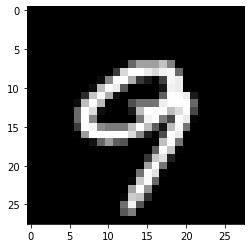

In [124]:
from random import randrange
choice = randrange(0,10000)
print(f"digit number {choice+1} of the test set",end = "\n\n")
show_image_and_pred(choice)  